# Aula 11 - Treinamento Machine Learning - FIAP + Alura

# Artificial Intelligence Tools & Examples - Classificação de Imagens com Redes Neurais Convolucionais (CNNs)

### Prof. Ahirton Lopes (profahirton.lopes@fiap.com.br)

# 1. Coleta de Dados - via API do Kaggle

In [20]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [21]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

Dataset URL: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images
License(s): Attribution 4.0 International (CC BY 4.0)
pneumonia-xray-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
import zipfile

zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# 2. Set up

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 2.1 Definindo Constantes e Parâmetros Base

In [24]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [25]:
#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500

# 3. Preparação de Dados

## 3.2 Data Augmentation (criando amostras artificiais)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,

                               )

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [27]:
type(train)

keras.src.legacy.preprocessing.image.DirectoryIterator

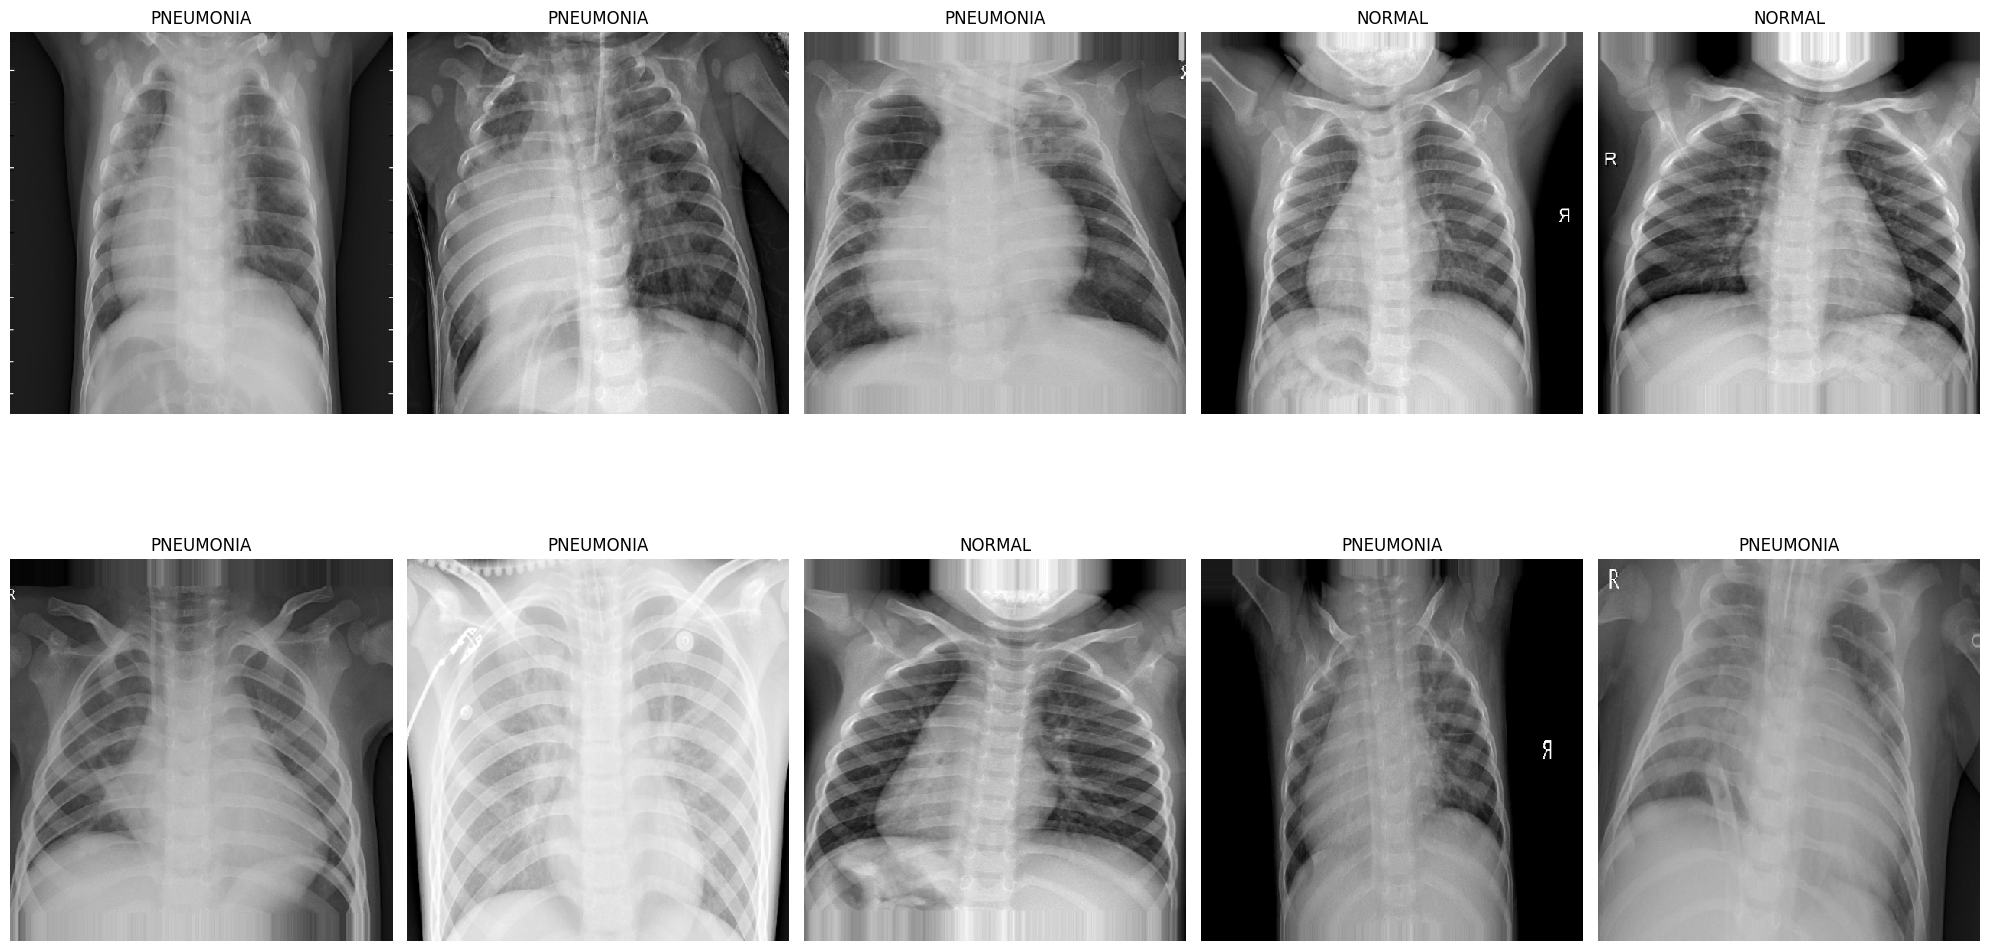

In [28]:
# showing examples
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

### Define

In [29]:
'''        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening

        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,# randomly flip images
        shear_range=0.2,
        brightness_range=(1.2, 1.5)'''

'        featurewise_center=False,  # set input mean to 0 over the dataset\n        samplewise_center=False,  # set each sample mean to 0\n        featurewise_std_normalization=False,  # divide inputs by std of the dataset\n        samplewise_std_normalization=False,  # divide each input by its std\n        zca_whitening=False,  # apply ZCA whitening\n\n        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)\n        zoom_range = 0.2, # Randomly zoom image\n        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)\n        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)\n        horizontal_flip = True,  # randomly flip images\n        vertical_flip=False,# randomly flip images\n        shear_range=0.2,\n        brightness_range=(1.2, 1.5)'

# 4. Criando nossa Rede Neural Artificial via Tensorflow/Keras

In [30]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 4.1 Modelo de Rede Neural Convolucional

In [31]:
# CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 498, 498, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 247, 247, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 123, 123, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 121, 121, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 58, 58, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,467,137 (5.60 MB)

 Trainable params: 1,467,137 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

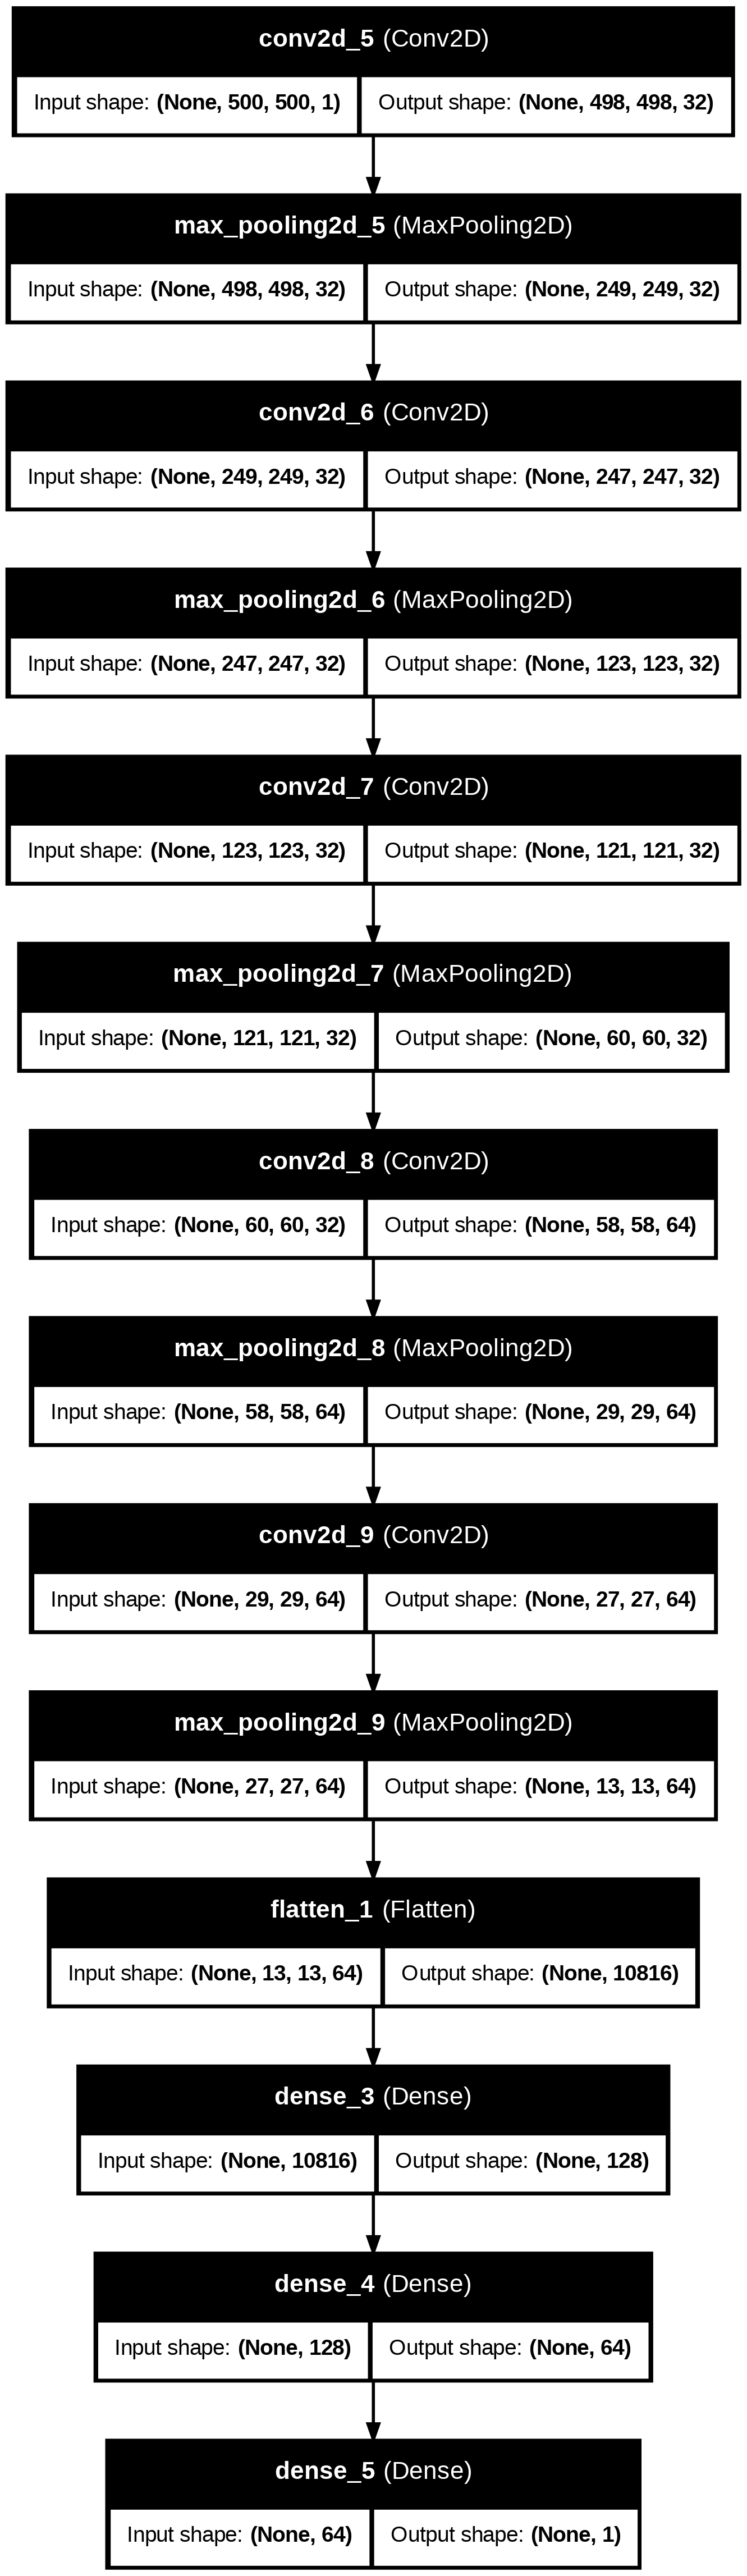

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 4.2 Ajustando o Modelo de Rede Neural (CNN)

In [34]:
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [35]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [36]:
cnn.fit(train,epochs=5, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 96s 351ms/step - accuracy: 0.5567 - loss: 0.5955 - val_accuracy: 0.7913 - val_loss: 0.4506 - learning_rate: 0.0010
Epoch 2/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 344ms/step - accuracy: 0.8836 - loss: 0.2965 - val_accuracy: 0.9144 - val_loss: 0.2151 - learning_rate: 0.0010
Epoch 3/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 344ms/step - accuracy: 0.9018 - loss: 0.2326 - val_accuracy: 0.9192 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 4/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 342ms/step - accuracy: 0.9198 - loss: 0.2053 - val_accuracy: 0.9231 - val_loss: 0.1930 - learning_rate: 0.0010
Epoch 5/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 90s 345ms/step - accuracy: 0.9247 - loss: 0.1867 - val_accuracy: 0.9356 - val_loss: 0.1850 - learning_rate: 0.0010


In [39]:
from google.colab import drive
drive.mount('/content/drive')

fp = "/content/drive/My Drive/cnn_pneu_vamp_model.keras"
cnn.save(fp)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
cnn = load_model(fp)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##4.3 Avaliação do Modelo

In [43]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8685 - loss: 0.3305
The testing accuracy is : 89.42307829856873 %


In [44]:
preds = cnn.predict(test,verbose=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step


In [45]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

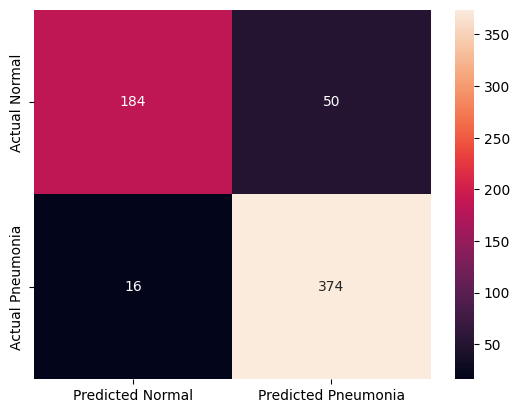

In [46]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [47]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.92      0.79      0.85       234
   PNEUMONIA       0.88      0.96      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



In [67]:
test.reset()

x = np.concatenate([test.__next__()[0] for i in range(len(test))])
y = np.concatenate([test.__next__()[1] for i in range(len(test))])

print(x.shape)
print(y.shape)


(624, 500, 500, 1)
(624,)


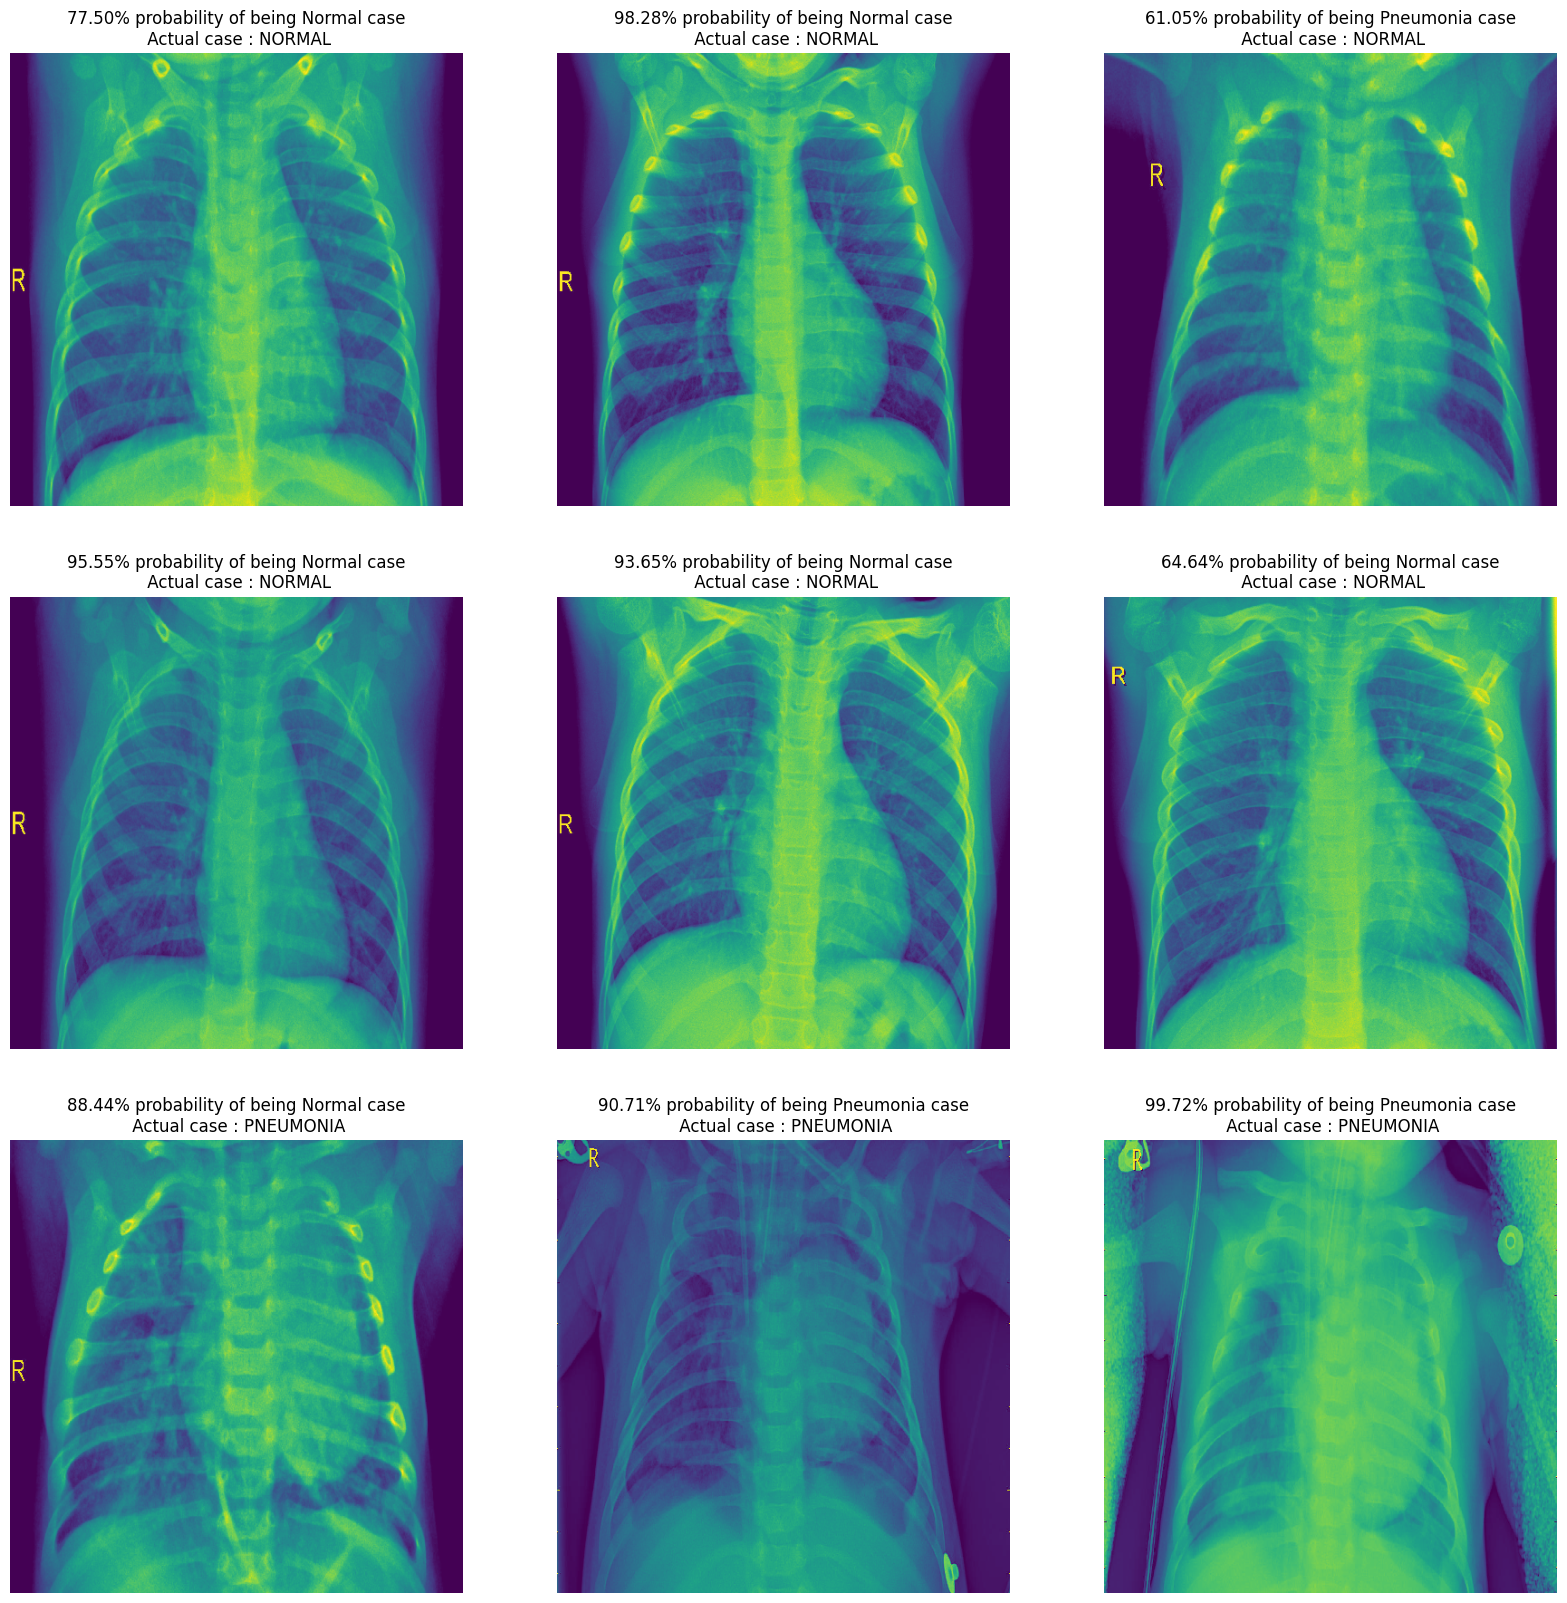

In [68]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5:
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))


  else:
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))



  plt.title(out+"\n Actual case : "+ dic.get(y[i]))
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [71]:
'''import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=y ) )
fig.show()'''

'import plotly.graph_objects as go\nfig = go.Figure( go.Scatter(y=y ) )\nfig.show()'

In [73]:
'''import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=predictions[:,0] ) )
fig.show()'''

'import plotly.graph_objects as go\nfig = go.Figure( go.Scatter(y=predictions[:,0] ) )\nfig.show()'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


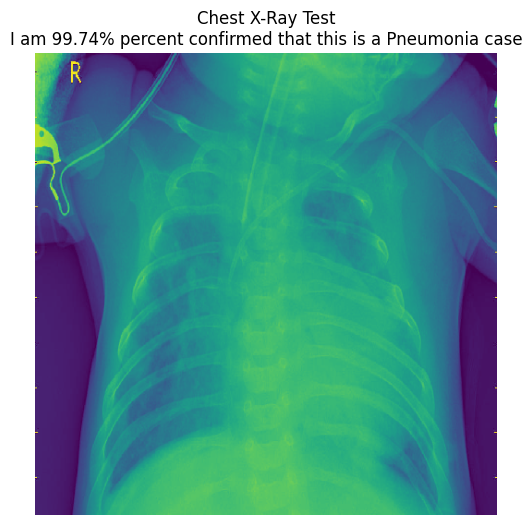

In [79]:
# Testing with my own Chest X-Ray
xray_path = '/content/drive/My Drive/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'

from tensorflow.keras.preprocessing import image

xray_img = image.load_img(xray_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_xray_img = image.img_to_array(xray_img)
pp_xray_img = pp_xray_img/255
pp_xray_img = np.expand_dims(pp_xray_img, axis=0)

#predict
xray_preds= cnn.predict(pp_xray_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if xray_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))

else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))


plt.title("Chest X-Ray Test\n"+out)
plt.imshow(np.squeeze(pp_xray_img))
plt.show()